In [8]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


In [28]:
def growing_degree_days(da_list, tbase, tupper=None):
    # Calculate growing degree days
    # Input: minimum temperature and maximum temperature, base temperature, upper temperature
    tmin = da_list[0] # Minimum temperature
    tmax = da_list[1] # Maximum temperature

    n_lats = len(tmin.lat)
    n_lons = len(tmin.lon)
    n_years = int(len(tmin.time)/365)

    growing_degree_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                tmin_i = tmin.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                tmax_i = tmax.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year

                t_avg = (tmin_i.values + tmax_i.values)/2.

                # Set average temperature equal to base temperature if it is lower than this sum
                t_avg = t_avg*(t_avg >= tbase) + np.ones(len(t_avg))*tbase*(t_avg < tbase)
                
                if tupper:
                    # Set average temperature equal to upper temperature if it is higher than this sum
                    t_avg = t_avg*(t_avg <= tupper) + np.ones(len(t_avg))*tupper*(t_avg > tupper)

                temp_diff = t_avg - tbase
                GDD = np.sum(temp_diff)

                growing_degree_days[lat, lon, year] = GDD
    
    return growing_degree_days

In [30]:
import numpy as np
t_avg = np.array([4, 5, 6, 8, 7, 0, 10, 3, 7, 8, 34])
tbase = 5
tupper = 30

print(t_avg)
# Set average temperature equal to base temperature if it is lower than this sum
t_avg = t_avg*(t_avg >= tbase) + np.ones(len(t_avg))*tbase*(t_avg < tbase)

print(t_avg)
if tupper:
    # Set average temperature equal to upper temperature if it is higher than this sum
    t_avg = t_avg*(t_avg < tupper) + np.ones(len(t_avg))*tupper*(t_avg > tupper)
print(t_avg)
temp_diff = t_avg - tbase
print(temp_diff)
GDD = np.sum(temp_diff)
GDD

[ 4  5  6  8  7  0 10  3  7  8 34]
[ 5.  5.  6.  8.  7.  5. 10.  5.  7.  8. 34.]
[ 5.  5.  6.  8.  7.  5. 10.  5.  7.  8. 30.]
[ 0.  0.  1.  3.  2.  0.  5.  0.  2.  3. 25.]


41.0

In [31]:
growing_degree_days([tmin, tmax], tbase=278.15, tupper=303.15)

array([[[1541.31573486, 1785.12817993, 1702.8494751 , ...,
         1468.01028442, 1600.4309021 , 1711.83848877],
        [1473.02611694, 1684.91962891, 1661.92342529, ...,
         1482.19465942, 1589.98972168, 1733.5869751 ],
        [1500.70820313, 1662.60703125, 1701.22885132, ...,
         1571.17932739, 1644.55819702, 1749.11105347],
        ...,
        [1695.17636108, 1439.76712646, 1621.2015625 , ...,
         1871.03564453, 1815.67127686, 1576.88764038],
        [1609.87470093, 1375.21124268, 1549.80324707, ...,
         1788.01782227, 1757.47874146, 1552.67046509],
        [1578.97376709, 1390.57747192, 1579.02751465, ...,
         1764.84627075, 1738.87050781, 1558.45787354]],

       [[1231.45021362, 1487.41263428, 1373.77445068, ...,
         1210.5536499 , 1311.66352539, 1388.35369873],
        [1096.39499512, 1234.66253662, 1219.77233276, ...,
         1150.21359863, 1234.82904663, 1356.13778687],
        [ 878.83250122,  869.63336182,  965.54399414, ...,
          937.

In [9]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_ssp126' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany': #UPDATE
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax = xr.open_mfdataset(files)

tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmax.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin = xr.open_mfdataset(files)

tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin.load()

<xarray.DataArray 'tasmin' (time: 14601, lat: 8, lon: 13)> Size: 6MB
array([[[273.3614 , 271.6733 , 269.38773, ..., 262.42883, 262.4719 ,
         262.62924],
        [273.06244, 269.13956, 259.00912, ..., 268.25894, 264.5443 ,
         262.66522],
        [273.70053, 268.65912, 256.0441 , ..., 262.61197, 263.0432 ,
         261.72565],
        ...,
        [271.24426, 272.30853, 272.85446, ..., 258.11313, 256.91815,
         256.5043 ],
        [269.452  , 270.92758, 271.97177, ..., 261.16495, 262.1215 ,
         264.3928 ],
        [268.0876 , 270.1765 , 269.54572, ..., 268.09714, 269.542  ,
         269.95227]],

       [[273.7263 , 272.46072, 270.1581 , ..., 262.43698, 261.91577,
         262.4874 ],
        [273.6518 , 270.5034 , 259.78983, ..., 268.45425, 263.24603,
         258.91605],
        [274.24197, 270.16592, 258.59772, ..., 261.72455, 257.24796,
         254.29459],
...
        [272.28632, 274.36877, 274.70578, ..., 260.6846 , 262.0461 ,
         265.70886],
        [269.69995, 272.24713, 273.79416, ..., 257.1634 , 263.9845 ,
         267.63345],
        [267.2852 , 270.2222 , 272.7994 , ..., 269.58737, 269.53616,
         269.14706]],

       [[277.49347, 276.84662, 276.51312, ..., 265.92093, 263.48846,
         259.90463],
        [277.13364, 274.57626, 268.16193, ..., 267.33005, 260.6958 ,
         261.84457],
        [275.71158, 271.39877, 260.522  , ..., 262.24658, 261.28616,
         254.01425],
        ...,
        [272.51358, 274.58426, 274.1952 , ..., 262.1167 , 262.2105 ,
         258.75092],
        [271.5211 , 274.18466, 274.4293 , ..., 262.7714 , 261.9295 ,
         265.48013],
        [270.50217, 273.80774, 274.00595, ..., 269.3773 , 269.81058,
         269.52658]]], dtype=float32)
Coordinates:
  * time     (time) object 117kB 2015-01-01 12:00:00 ... 2055-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-12-06T14:55:16Z altered by CMOR: Treated scalar dime...

In [ ]:
# Choose which variable to calculate

variable_name = 'GDD'
unit = 'Kelvin/year'
description = 'Growing degree days'
input_values = [tmin, tmax]
values = PRCPTOT(input_values)

# Save data as netcdf file

ds = xr.Dataset(
    data_vars=dict(
        variable=(["lat", "lon", "time"], values)
    ),
    coords=dict(
        lat=input_values[0].lat.values,
        lon=input_values[0].lon.values,
        time=time_array,
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'
ds = ds.rename_vars(dict(variable=variable_name))
ds[variable_name].attrs['units'] = unit
ds[variable_name].attrs['description'] = description

ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
ds

<xarray.DataArray (lat: 8, lon: 13, time: 40)> Size: 33kB
array([[[ 46.,  29.,  13., ..., 267.,  10.,  18.],
        [ 36.,  24.,   9., ..., 238.,   3.,  17.],
        [ 34.,  32.,  10., ..., 236., 266.,  16.],
        ...,
        [203.,   6., 169., ..., 205., 186., 191.],
        [198.,   6., 168., ..., 171., 188., 191.],
        [197., 195., 167., ..., 170., 183., 191.]],

       [[279.,  23.,  13., ...,  10.,   3.,  16.],
        [216.,  29.,  13., ..., 209.,  81.,  15.],
        [158., 149.,   9., ..., 177., 180.,   5.],
        ...,
        [202., 205., 191., ..., 185., 201., 206.],
        [198., 184., 168., ..., 184., 184., 163.],
        [197., 184., 167., ..., 184.,   3., 162.]],

       [[277.,  23.,  12., ...,   2.,   2.,  11.],
        [184., 241.,  12., ..., 176.,  21., 161.],
        [151., 132., 135., ..., 160., 130., 130.],
        ...,
...
        ...,
        [139.,  92., 130., ..., 114., 115.,  32.],
        [139.,  93., 130., ..., 114., 116.,  34.],
        [124., 

Text(0.5, 1.0, 'Change in growing season length')

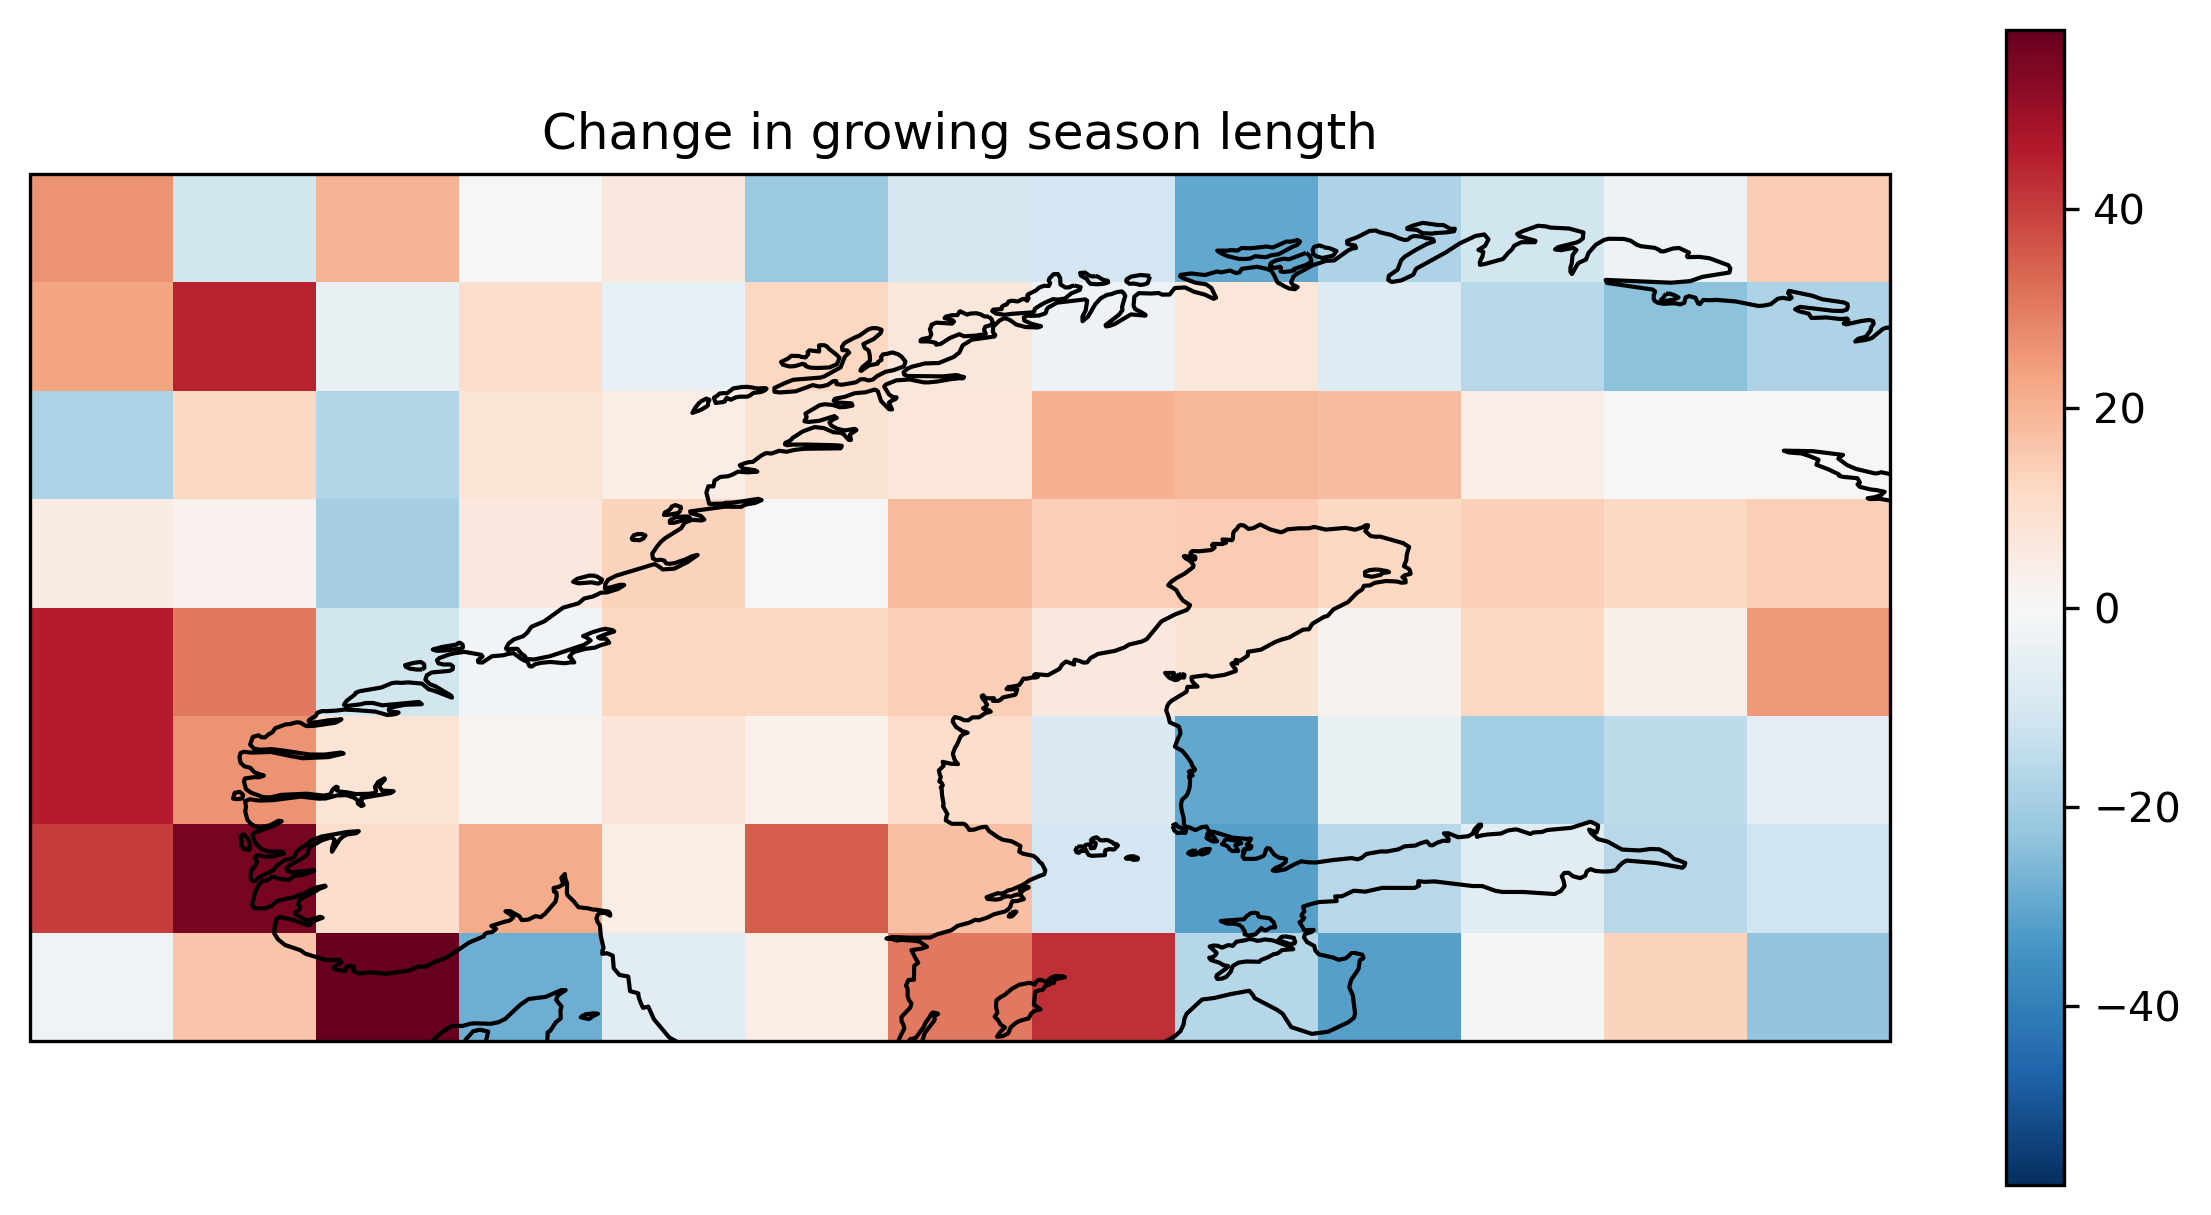

In [128]:
GSL_Norway = xr.open_dataarray("GSL_Norway_NorESM2.nc")
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = da.isel(time=slice(20,40)).mean("time") - da.isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in growing season length")

In [4]:
pre_SPG = tas_NorESM.tas.sel(time=slice('2015-01-01', '2035-01-01')).mean('time')
post_SPG = tas_NorESM.tas.sel(time=slice('2035-01-01','2055-01-01')).mean('time')

In [6]:
norway_pre_SPG = pre_SPG.sel(lat=slice(57.6, 72.8), lon=slice(1.4, 34.7))
norway_post_SPG = post_SPG.sel(lat=slice(57.6, 72.8), lon=slice(1.4, 34.7))

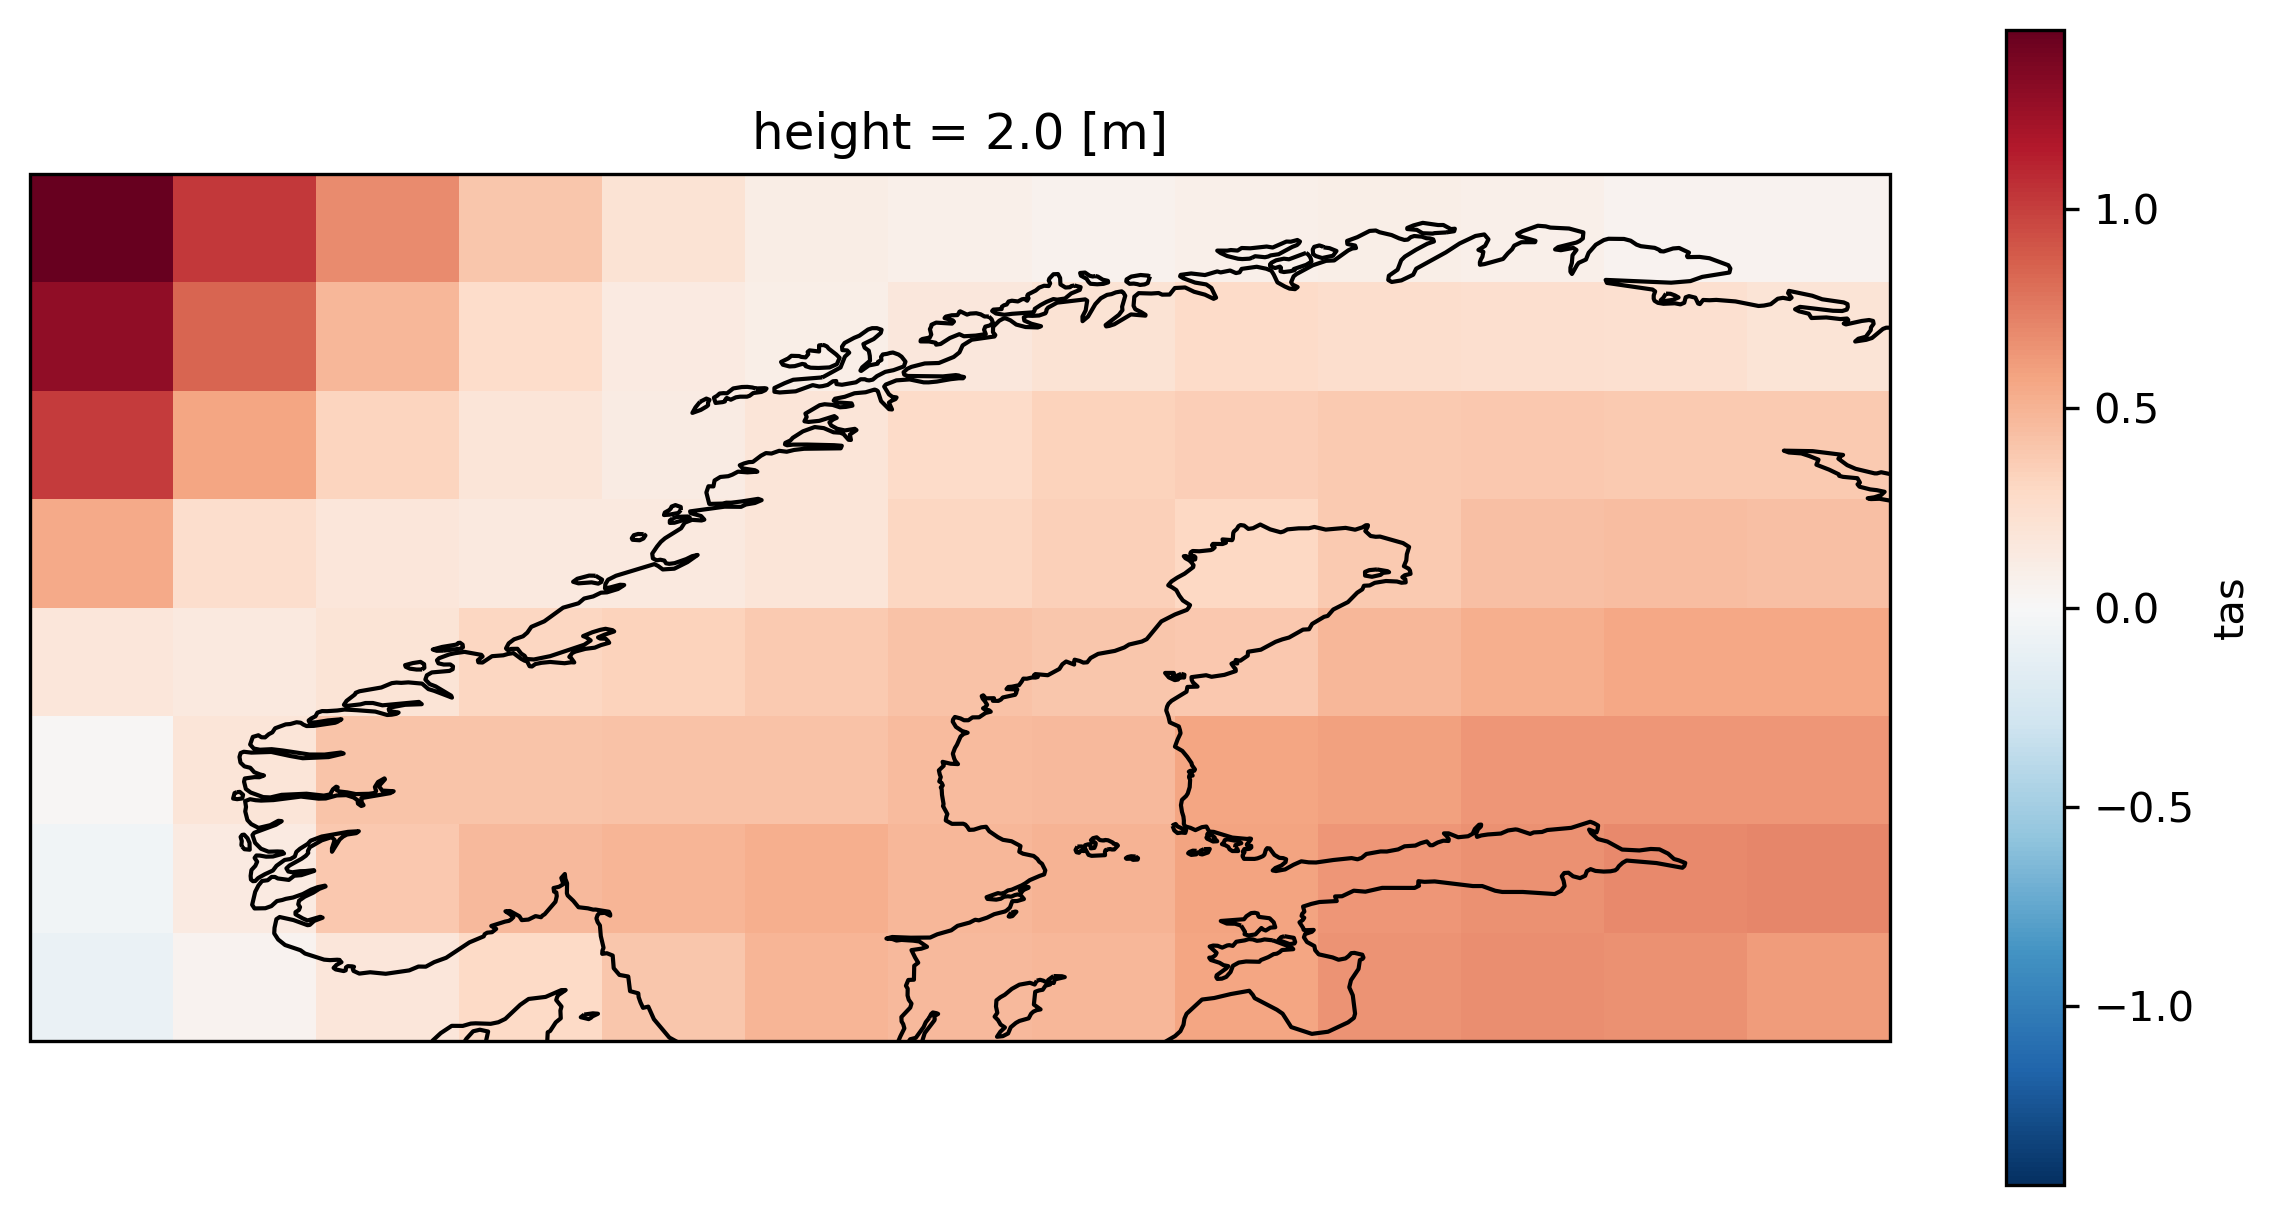

In [7]:
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = norway_post_SPG - norway_pre_SPG
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()

In [ ]:
ds = tas_NorESM.tas.sel(lat=slice(57.6, 72.8), 
                                    lon=slice(1.4, 34.7), 
                                    time=slice('2015-01-01', '2055-01-01'))

growing_season_length = np.zeros((len(ds.lat), len(ds.lon), 40))
print(len(ds.lat))
print(len(ds.lon))
quit()

for lat in range(len(ds.lat)):
    for lon in range(len(ds.lon)):
        for year in range(40):
            count = 0
            length = 0
            print("Year: ",year)
            for day in range(365):
                print("Day: ",day)
                print(ds.isel(lat=lat, lon=lon, time=year+day).values)
                if ds.isel(lat=lat, lon=lon, time=year+day) >= 273.15 + 5:
                    count += 1
                elif count < 7 and ds.isel(lat=lat, lon=lon, time=year+day) < 273.15 + 5 :
                    count = 0
                elif count >= 7 and ds.isel(lat=lat, lon=lon, time=year+day) < 273.15 + 5:
                    length = np.max([count, length])
                    count = 0
                print(count)
            print(length)
            growing_season_length[lat, lon, year] = length

print(growing_season_length)
np.save("norway_growing_season_length.npy", growing_season_length)



8
13
Year:  0
0
Day:  0
273.6078
0
Day:  1
274.28915
0
Day:  2
277.26318
0
Day:  3
279.50214
1
Day:  4
276.1278
0
Day:  5
275.4586
0
Day:  6
276.806
0
Day:  7
279.93054
1
Day:  8
277.14023
0
Day:  9
275.24802
0
Day:  10
276.99677
0
Day:  11
279.89813
1
Day:  12
279.26163
2
Day:  13
276.59573
0
Day:  14
277.40717
0
Day:  15
277.492
0
Day:  16
277.25272
0
Day:  17
278.40753
1
Day:  18
277.73404
0
Day:  19
277.70007
0
Day:  20
277.71692
0
Day:  21
277.9159
0
Day:  22
278.7782
1
Day:  23
278.72116
2
Day:  24
277.0775
0
Day:  25
275.98654
0
Day:  26
276.79288
0
Day:  27
279.4131
1
Day:  28
280.70535
2
Day:  29
280.65182
3
Day:  30
281.13617
4
Day:  31
280.1855
5
Day:  32
280.24554
6
Day:  33
280.39404
7
Day:  34
278.9038
8
Day:  35
278.7942
9
Day:  36
279.88986
10
Day:  37
279.06796
11
Day:  38
280.20908
12
Day:  39
280.7428
13
Day:  40
280.3502
14
Day:  41
279.17746
15
Day:  42
278.56757
16
Day:  43
279.36044
17
Day:  44
279.98737
18
Day:  45
280.71893
19
Day:  46
281.13275
20
Day:  47
281

KeyboardInterrupt: 

: 

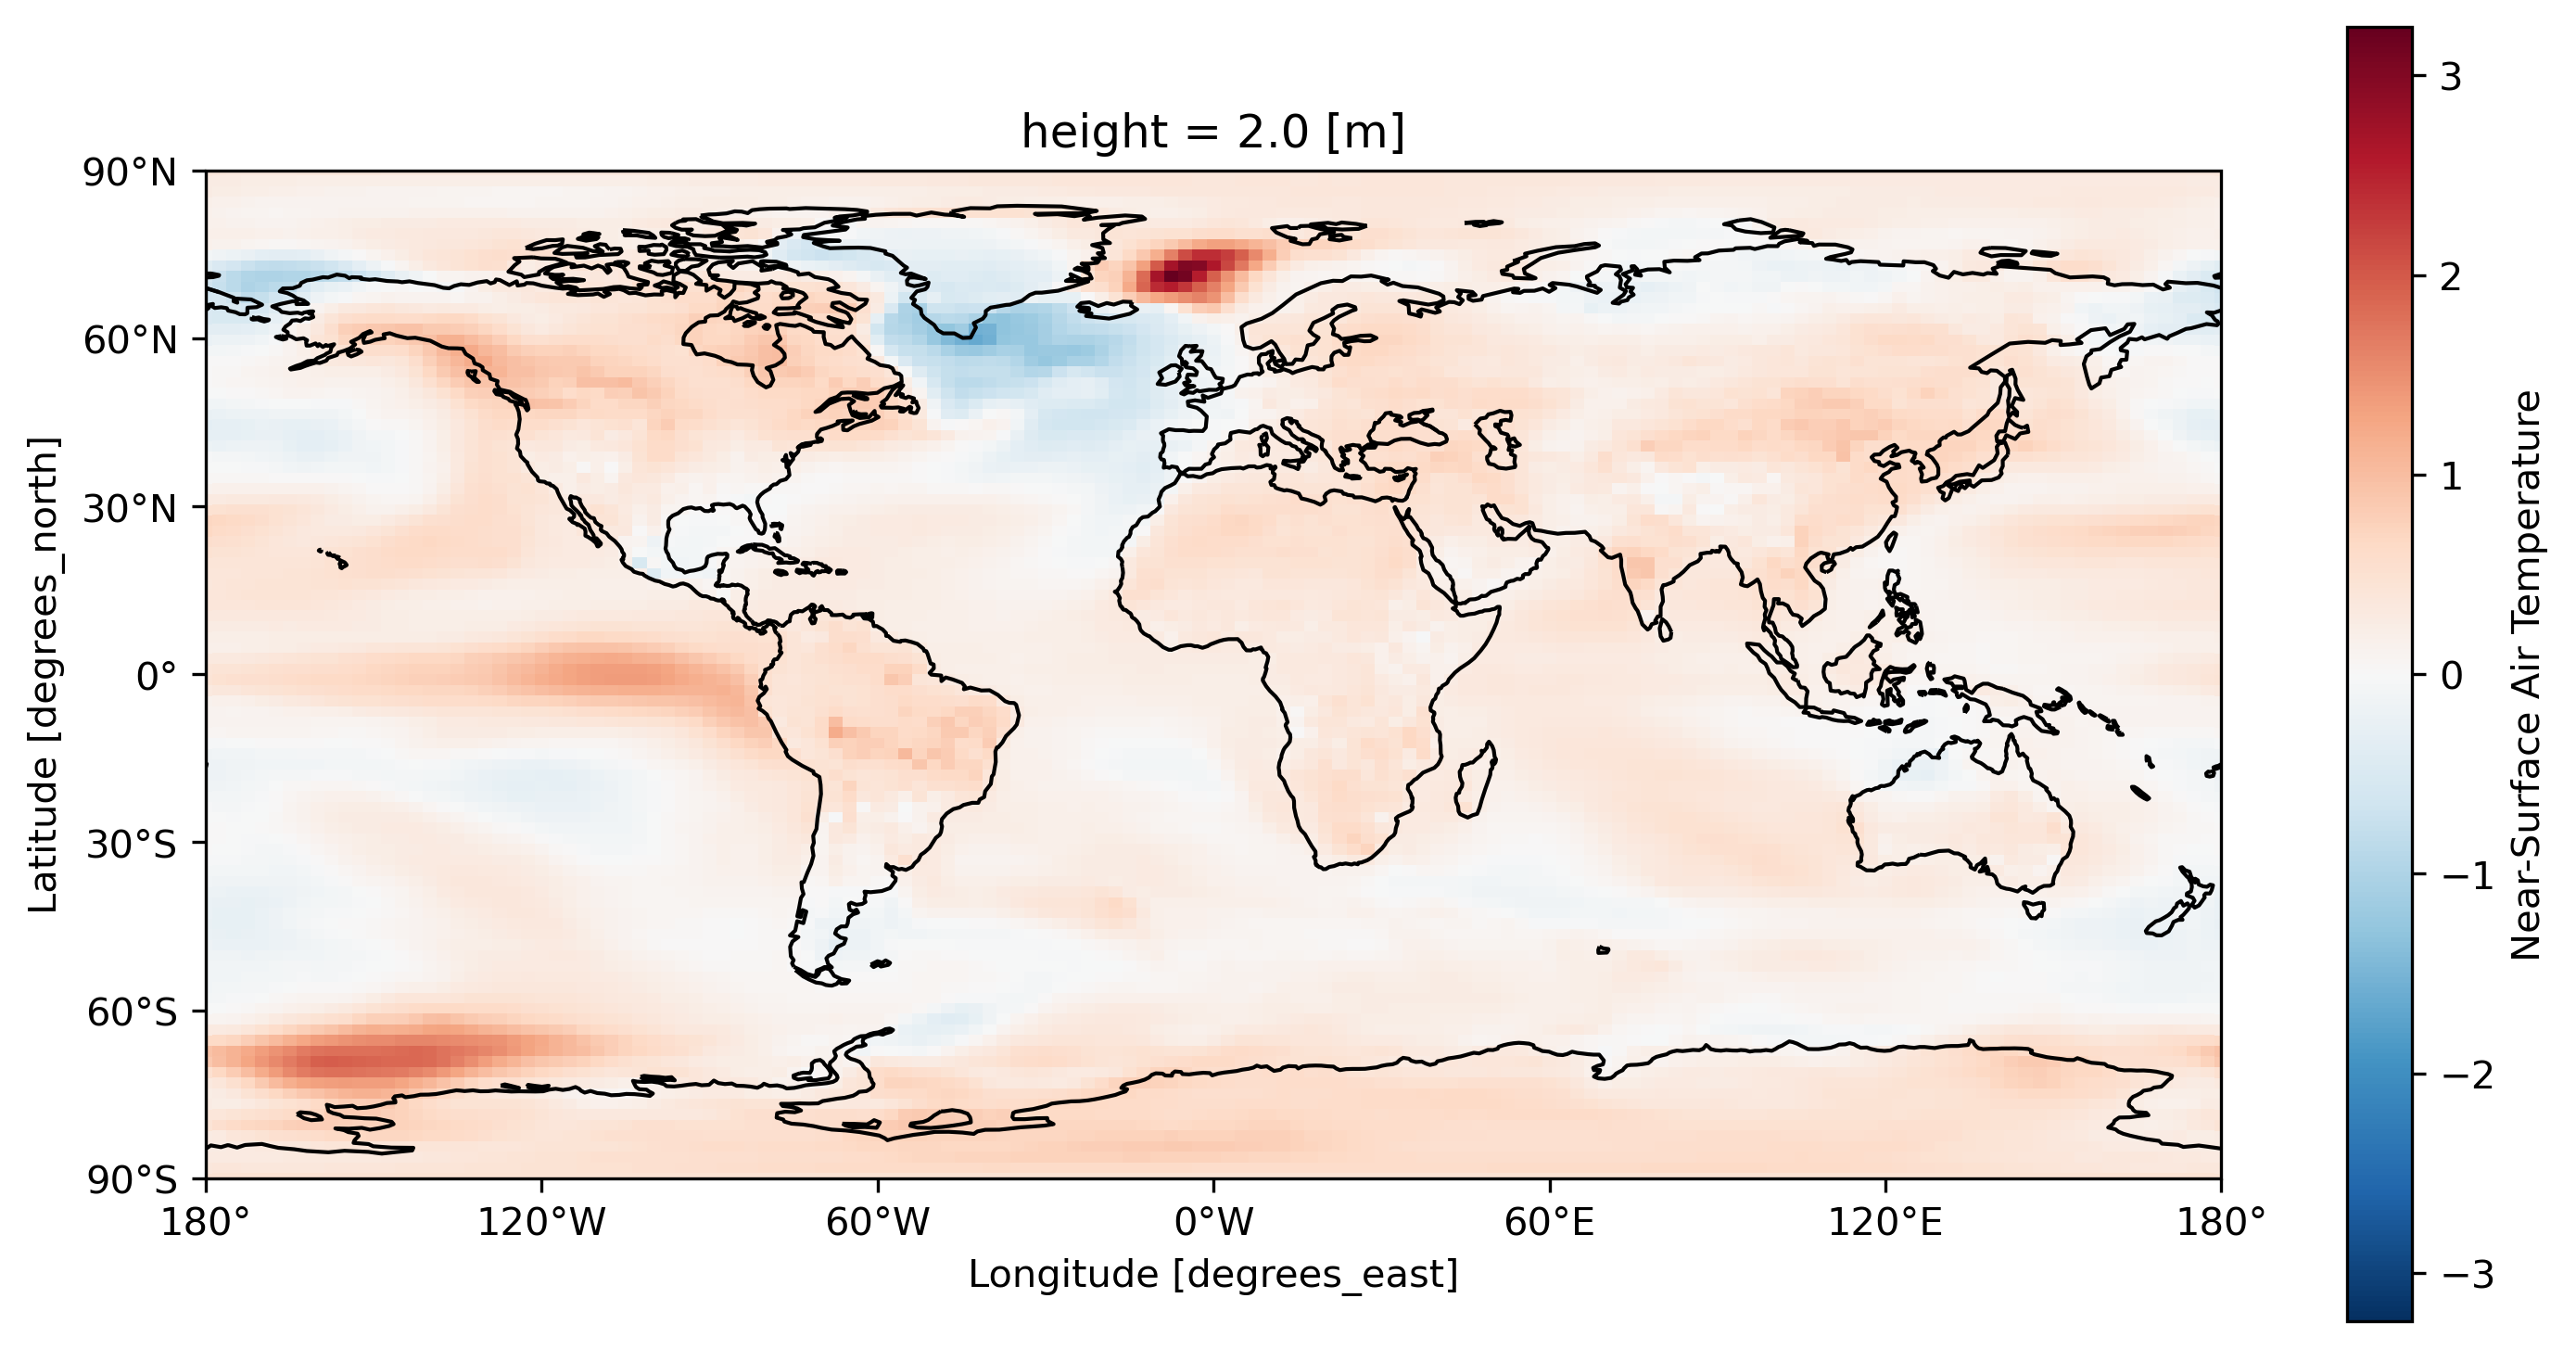

In [13]:
fig = plt.figure(1, figsize=(10,5), dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
plt.title(tas_NorESM.tas.long_name)
diff = post_SPG - pre_SPG
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree(),
                cbar_kwargs={"label": "Near-Surface Air Temperature"})
ax.coastlines()
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
   
ax.xaxis.set_major_formatter(LongitudeFormatter(zero_direction_label=True))
ax.yaxis.set_major_formatter(LatitudeFormatter())

### COLORBAR ###
#cb = fig.colorbar(map, label=tas_NorESM.tas.long_name, extend='max', orientation="horizontal", shrink=0.5, pad=0.05)

plt.tight_layout()